In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Import Required Libraries

In [1]:
#import required libraries — we do need the models, flatten, dense, input layers
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

#2. Import the Dataset from Roboflow Website

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wBhhcFexJ3QDDrx6zu0d")
project = rf.workspace("sdaia-xqoon").project("capstone-avmph")
dataset = project.version(8).download("tensorflow")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninsta

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Capstone-8 in tensorflow:: 100%|██████████| 12452/12452 [00:02<00:00, 5351.55it/s]


# 3. Change the Annotations of Train, Validation, and test sets

## 3.1. Change Train Annotations

In [9]:
import pandas as pd
df = pd.read_csv('/content/Capstone-8/train/_annotations.csv')
# Rename the class column to label
df.rename(columns={'class':'label'},inplace = True)
# Drop the Width, Hight columns from the annotation
df.drop(['width','height'],axis=1,inplace=True)
df.head()

,filename,label,xmin,ymin,xmax,ymax
0,e8ade2c1f9d2fb67cfc42e9bcb30514e_jpg.rf.ac4ce3...,garbage,36,318,59,333
1,39c73f33d982939742f3de50d22fcab7_jpg.rf.ad180e...,construction_waste,5,147,329,264
2,2867d05fe051716848caa71bb08a23a0_jpg.rf.ad11b3...,garbage,120,255,162,292
3,2867d05fe051716848caa71bb08a23a0_jpg.rf.ad11b3...,garbage,46,299,69,313
4,4ef6f52a2a2a2ca404f1705422cab526_jpg.rf.ac5cdb...,bad_billboard,564,271,635,314


In [4]:
# Save train annotation
df.to_csv('/content/Capstone-8/train/_annotations.csv',index=False)

In [55]:
import os
import cv2
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

# Path to the folder containing the images
image_folder = '/content/Capstone-8/train/'

# Path to the CSV file
csv_file = '/content/Capstone-8/train/_annotations.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Create a dictionary to map string labels to integer labels
label_mapping_train = {label: index for index, label in enumerate(df['label'].unique())}

# Prepare the inputs and labels for training
train_images = []
train_labels = []

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    image_name = row['filename']
    label = row['label']
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    # Construct the image path
    image_path = os.path.join(image_folder, image_name)

    # Read and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
     # Append the preprocessed image and label to the training data
    train_images.append(img)
    train_labels.append(label_mapping_train[label])

# Convert the training data to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Convert labels to one-hot encoded format
train_labels = to_categorical(train_labels)

### 3.1.1. Normalize Train Data

In [56]:
images_train = []
for filename in df['filename']:
    img_path = os.path.join(image_folder, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0  # normalize pixel values
    images_train.append(img)

train_images = np.array(images_train)

## 3.2. Change Valid Annotations

In [10]:
import pandas as pd
df = pd.read_csv('/content/Capstone-8/valid/_annotations.csv')
# Rename the class column to label
df.rename(columns={'class':'label'},inplace = True)
# Drop the Width, Hight columns from the annotation
df.drop(['width','height'],axis=1,inplace=True)
df.head()

,filename,label,xmin,ymin,xmax,ymax
0,db4d5f4a2e9a47b47257108c2a4f8a5f_jpg.rf.00b8d2...,sand_on_road,2,218,640,640
1,8bcb73272c09dba9a8986765d182dfb8_jpg.rf.00c04f...,garbage,578,387,603,425
2,8bcb73272c09dba9a8986765d182dfb8_jpg.rf.00c04f...,graffiti,523,201,563,236
3,8bcb73272c09dba9a8986765d182dfb8_jpg.rf.00c04f...,graffiti,620,218,640,259
4,10f6c655e48450f087671c60ceaac251_jpg.rf.00bbe2...,bad_billboard,187,31,302,116


In [7]:
# Save valid annotation
df.to_csv('/content/Capstone-8/valid/_annotations.csv',index=False)

In [54]:
import os
import cv2
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

# Path to the folder containing the images
image_folder = '/content/Capstone-8/valid/'

# Path to the CSV file
csv_file = '/content/Capstone-8/valid/_annotations.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Create a dictionary to map string labels to integer labels
label_mapping_valid = {label: index for index, label in enumerate(df['label'].unique())}

# Prepare the inputs and labels for training
valid_images = []
valid_labels = []

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    image_name = row['filename']
    label = row['label']
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    # Construct the image path
    image_path = os.path.join(image_folder, image_name)

    # Read and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
     # Append the preprocessed image and label to the training data
    valid_images.append(img)
    valid_labels.append(label_mapping_valid[label])

# Convert the training data to numpy arrays
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Convert labels to one-hot encoded format
valid_labels = to_categorical(valid_labels)

### 3.2.1. Normalize Valid Data

In [53]:
images_valid = []
for filename in df['filename']:
    img_path = os.path.join(image_folder, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0  # normalize pixel values
    images_valid.append(img)

valid_images = np.array(images_valid)

## 3.3. Change Test Annotations

In [11]:
import pandas as pd
df = pd.read_csv('/content/Capstone-8/test/_annotations.csv')
# Rename the class column to label
df.rename(columns={'class':'label'},inplace = True)
# Drop the Width, Hight columns from the annotation
df.drop(['width','height'],axis=1,inplace=True)
df.head()

,filename,label,xmin,ymin,xmax,ymax
0,9224dd81923e76fa27c143359185718d_jpg.rf.051d0f...,garbage,280,373,306,405
1,9224dd81923e76fa27c143359185718d_jpg.rf.051d0f...,construction_waste,195,329,241,435
2,20d37ff709ed6cbb8767b5ffe1753a08_jpg.rf.080a7a...,graffiti,393,144,459,262
3,20d37ff709ed6cbb8767b5ffe1753a08_jpg.rf.080a7a...,sand_on_road,410,236,518,302
4,5dbfc0f02581fc3379a6eb5b7132b939_jpg.rf.06bf23...,construction_road,0,294,394,435


In [12]:
# Save test annotation
df.to_csv('/content/Capstone-8/test/_annotations.csv',index=False)

In [57]:
import os
import cv2
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

# Path to the folder containing the images
image_folder = '/content/Capstone-8/test/'

# Path to the CSV file
csv_file = '/content/Capstone-8/test/_annotations.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Create a dictionary to map string labels to integer labels
label_mapping_test = {label: index for index, label in enumerate(df['label'].unique())}

# Prepare the inputs and labels for training
test_images = []
test_labels = []

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    image_name = row['filename']
    label = row['label']
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    # Construct the image path
    image_path = os.path.join(image_folder, image_name)

    # Read and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
     # Append the preprocessed image and label to the training data
    test_images.append(img)
    test_labels.append(label_mapping_test[label])

# Convert the training data to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Convert labels to one-hot encoded format
test_labels = to_categorical(test_labels)

### 3.3.1. Normalize Test Data

In [58]:
images_test = []
for filename in df['filename']:
    img_path = os.path.join(image_folder, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0  # normalize pixel values
    images_test.append(img)

test_images = np.array(images_test)

# 4. Download VGG16 model

In [50]:
# Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have.
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights
vgg.trainable = False ## Not trainable weights

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##4.1. Modify the Model Layers

In [51]:
from tensorflow.keras.layers import Conv2D
# Add our layers
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted.
for layer in vgg.layers:
  layer.trainable = False

x = Conv2D(70, (1, 1), activation='relu')(vgg.output)
f1 = Flatten()(x) #Output obtained on vgg16 is now flattened.
d2 = Dense(70, activation='relu')(f1)
prediction = Dense(9, activation='softmax')(d2) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes
#Creating model object
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## 4.1.1. Draw the Model Architecture


In [20]:
!pip install pydot

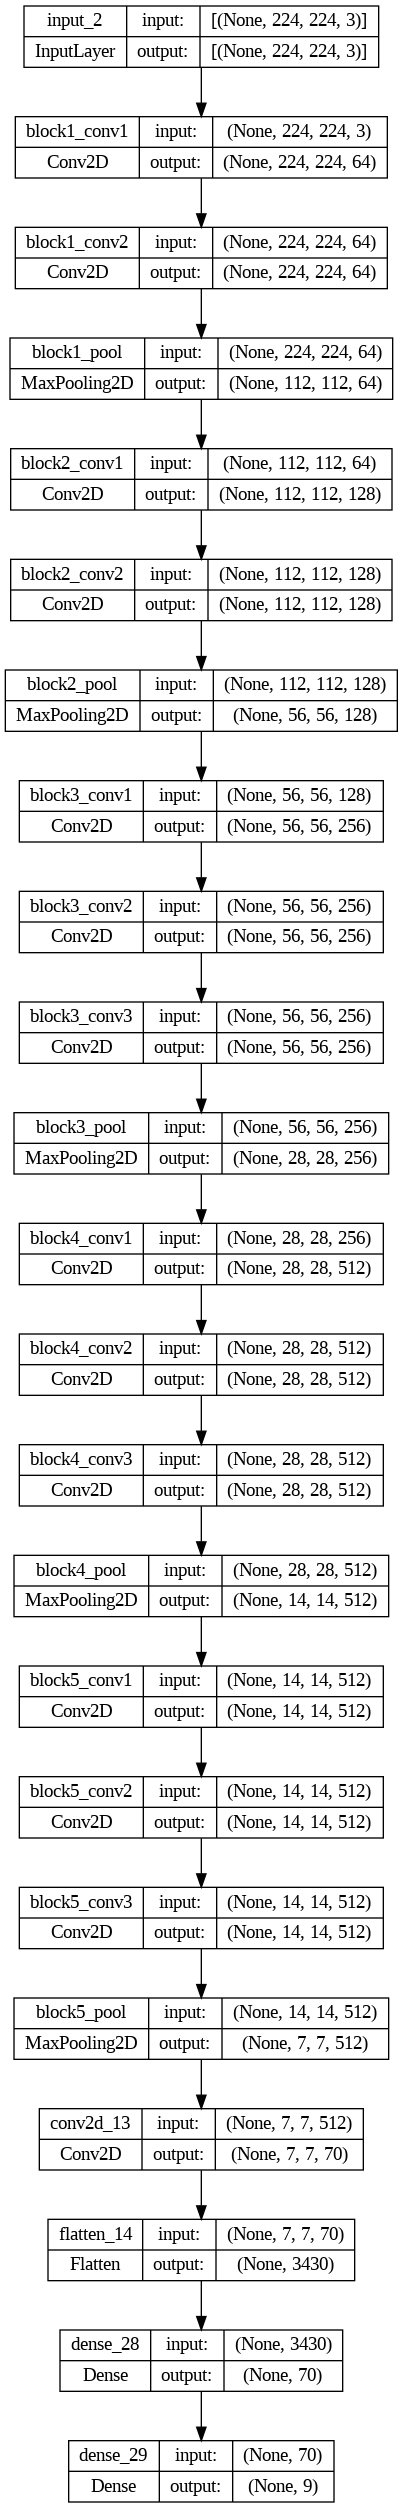

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

## 4.2. Train the Model

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_labels , validation_data=(valid_images, valid_labels ), epochs=50, batch_size=64, callbacks=[es])

Epoch 1/50
318/318 [==============================] - 16s 46ms/step - loss: 0.6558 - accuracy: 0.7471 - val_loss: 172.7025 - val_accuracy: 0.0836
Epoch 2/50
318/318 [==============================] - 13s 40ms/step - loss: 0.6218 - accuracy: 0.7543 - val_loss: 172.9892 - val_accuracy: 0.0846
Epoch 3/50
318/318 [==============================] - 13s 40ms/step - loss: 0.6009 - accuracy: 0.7599 - val_loss: 199.3133 - val_accuracy: 0.0856
Epoch 4/50
318/318 [==============================] - 13s 40ms/step - loss: 0.5865 - accuracy: 0.7651 - val_loss: 211.1196 - val_accuracy: 0.0771
Epoch 5/50
318/318 [==============================] - 13s 40ms/step - loss: 0.5647 - accuracy: 0.7675 - val_loss: 219.8124 - val_accuracy: 0.0861
Epoch 6/50
318/318 [==============================] - 13s 39ms/step - loss: 0.5593 - accuracy: 0.7710 - val_loss: 216.9063 - val_accuracy: 0.0746
Epoch 7/50
318/318 [==============================] - 13s 40ms/step - loss: 0.5430 - accuracy: 0.7745 - val_loss: 233.8062 -

In [61]:
print(label_mapping_test)

{'garbage': 0, 'construction_waste': 1, 'graffiti': 2, 'sand_on_road': 3, 'construction_road': 4, 'potholes': 5, 'bad_billboard': 6, 'clutter_sidewalk': 7, 'broken_signage': 8}


# 5. Predict & Visulize some images

1/1 [==============================] - 0s 22ms/step


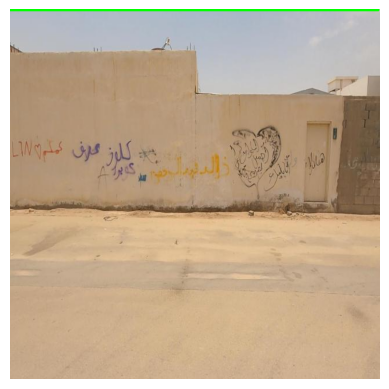

In [66]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the image file
image_path = '/content/Capstone-8/test/04c74fb6ff31ac072c204d468ae5b7de_jpg.rf.b6bb903aa921d203fa2bf713b24c6c8c.jpg'

label_mapping_tests = {
    0: 'garbage',
    1: 'construction_waste',
    2: 'graffiti',
    3: 'sand_on_road',
    4: 'construction_road',
    5: 'potholes',
    6: 'bad_billboard',
    7: 'clutter_sidewalk',
    8: 'broken_signage',
}
# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = preprocess_input(img)

# Reshape the image to match the model's input shape
img = np.expand_dims(img, axis=0)

# Make predictions on the image using the trained model
predictions = model.predict(img)
# Get the predicted label and bounding box coordinates
predicted_label = np.argmax(predictions, axis=1)[0]
bounding_box = predictions[0, 1:]  # Assuming the 0th index corresponds to the background class

# Create a dictionary to map integer labels back to their respective string labels
label_mapping_inverse = {index: label for label, index in label_mapping_tests.items()}

# Read the image
img = cv2.imread(image_path)

# Get the image dimensions
height, width, _ = img.shape

# Extract the bounding box coordinates
xmin = int(bounding_box[0] * width)
ymin = int(bounding_box[1] * height)
xmax = int(bounding_box[2] * width)
ymax = int(bounding_box[3] * height)

# Draw the bounding box on the image
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Get the predicted label
predicted_label = label_mapping_inverse.get(predicted_label, "Unknown label")

# Add the predicted label text to the image
label_text = f"Label: {predicted_label}"
cv2.putText(img, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding box and predicted label using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step


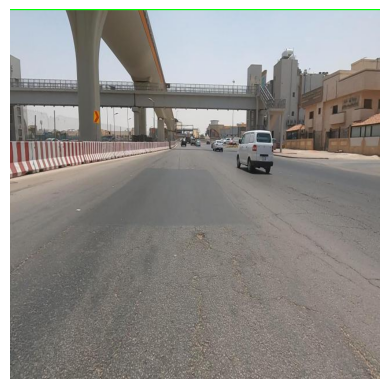

In [70]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the image file
image_path ='/content/Capstone-8/test/3518d589fbf05f96e35a59630f5eb594_jpg.rf.b89b80c3ac3a2ce42c4d7f3877622f94.jpg'

label_mapping_tests = {
    0: 'garbage',
    1: 'construction_waste',
    2: 'graffiti',
    3: 'sand_on_road',
    4: 'construction_road',
    5: 'potholes',
    6: 'bad_billboard',
    7: 'clutter_sidewalk',
    8: 'broken_signage',
}
# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = preprocess_input(img)

# Reshape the image to match the model's input shape
img = np.expand_dims(img, axis=0)

# Make predictions on the image using the trained model
predictions = model.predict(img)
# Get the predicted label and bounding box coordinates
predicted_label = np.argmax(predictions, axis=1)[0]
bounding_box = predictions[0, 1:]  # Assuming the 0th index corresponds to the background class

# Create a dictionary to map integer labels back to their respective string labels
label_mapping_inverse = {index: label for label, index in label_mapping_tests.items()}

# Read the image
img = cv2.imread(image_path)

# Get the image dimensions
height, width, _ = img.shape

# Extract the bounding box coordinates
xmin = int(bounding_box[0] * width)
ymin = int(bounding_box[1] * height)
xmax = int(bounding_box[2] * width)
ymax = int(bounding_box[3] * height)

# Draw the bounding box on the image
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Get the predicted label
predicted_label = label_mapping_inverse.get(predicted_label, "Unknown label")

# Add the predicted label text to the image
label_text = f"Label: {predicted_label}"
cv2.putText(img, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding box and predicted label using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step


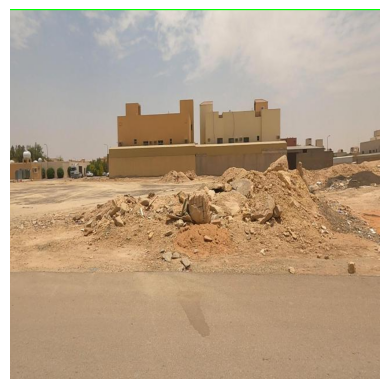

In [71]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to the image file
image_path ='/content/Capstone-8/test/59c381218eee247398087a0d8a5052cd_jpg.rf.380437fca6e565a662bd072e0359ec6d.jpg'

label_mapping_tests = {
    0: 'garbage',
    1: 'construction_waste',
    2: 'graffiti',
    3: 'sand_on_road',
    4: 'construction_road',
    5: 'potholes',
    6: 'bad_billboard',
    7: 'clutter_sidewalk',
    8: 'broken_signage',
}
# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = preprocess_input(img)

# Reshape the image to match the model's input shape
img = np.expand_dims(img, axis=0)

# Make predictions on the image using the trained model
predictions = model.predict(img)
# Get the predicted label and bounding box coordinates
predicted_label = np.argmax(predictions, axis=1)[0]
bounding_box = predictions[0, 1:]  # Assuming the 0th index corresponds to the background class

# Create a dictionary to map integer labels back to their respective string labels
label_mapping_inverse = {index: label for label, index in label_mapping_tests.items()}

# Read the image
img = cv2.imread(image_path)

# Get the image dimensions
height, width, _ = img.shape

# Extract the bounding box coordinates
xmin = int(bounding_box[0] * width)
ymin = int(bounding_box[1] * height)
xmax = int(bounding_box[2] * width)
ymax = int(bounding_box[3] * height)

# Draw the bounding box on the image
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

# Get the predicted label
predicted_label = label_mapping_inverse.get(predicted_label, "Unknown label")

# Add the predicted label text to the image
label_text = f"Label: {predicted_label}"
cv2.putText(img, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding box and predicted label using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()